In [6]:
import xarray as xr    
import numpy as np
import pandas as pd

ds = xr.open_dataset("goa_discharge_time_series_cfsr_19790901_20140831.nc", decode_times=False)

In [2]:
import datetime
t = ds.time[0].data
times = [datetime.datetime.fromordinal(int(t)) + datetime.timedelta(days=t%1) - datetime.timedelta(days=366) for t in ds.time.data]

In [3]:
ds2 = ds.set_coords({'time': pd.to_datetime(times)})

In [4]:
q = (xr.DataArray(ds.q.data, dims=('loc', 'time'), coords={'time': pd.to_datetime(times)}))*86400
lat = xr.DataArray(ds.lat.data, dims=('loc',))
lon = xr.DataArray(ds.lon.data, dims=('loc',))
ds2 = xr.Dataset(dict(q=q, lat=lat, lon=lon))
waterYears = [t.year+1 if t.month >= 9 else t.year for t in pd.DatetimeIndex(ds2.time.data)]
wy = xr.DataArray(waterYears, dims=('time'), name='wy')
ds2['wy'] = wy
qsum = xr.DataArray(ds2.swap_dims({'time': 'wy'}).q.groupby('wy').sum().data, dims=('loc', 'year'), coords={'year': range(1980, 2015)})

In [13]:
yearly = xr.Dataset(dict(q=qsum, lat=ds2.lat, lon=ds2.lon))
yrly_df = xr.Dataset.to_dataframe(yearly)
df_yr = yrly_df.pivot_table(index=['loc', 'lat', 'lon'], columns='year', values='q')
df_yr.to_csv('q_yearly.csv')

In [10]:
total = (df_yr.sum())/1000000000
total.name = 'Q_yr'
df_yr = df_yr.append(total.transpose())

In [12]:
FWD_yr = df_yr.loc['Q_yr', '1980':'2014']
FWD_yr.to_csv('Q_FWD.csv')

In [14]:
q_cgd = pd.read_csv('Q_CGD_lon.csv')

In [15]:
step = 0.1
to_bin = lambda x: np.floor(x / step) * step
q_cgd['lonbin'] = q_cgd.lon.map(to_bin)
cgd_grp = (q_cgd.groupby('lonbin').sum().loc[:, 'qmean7913'])/1000000000
cgd_area_grp = q_cgd.groupby('lonbin').sum().loc[:, 'CC_Area_km2']

In [16]:
df_grp = pd.merge(cgd_grp, cgd_area_grp, right_index=True, left_index=True)
df = df_grp.reset_index()

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, LinearLocator)
import seaborn as sns

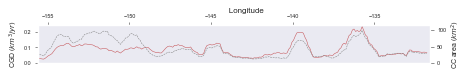

In [18]:
sns.set(font_scale=0.5)
sns.set_style('dark')

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(1,1, figsize=(6.5, 1.0))
plt.subplots_adjust(wspace=0, hspace=0)

ax2 = ax.twinx()

ax.tick_params(length=3.5, width=0.5)
ax2.tick_params(length=3.5, width=0.5)

sns.lineplot(data=df.rolling(10).mean(), x='lonbin', y='CC_Area_km2', color='grey', ax=ax2, linewidth=0.5)

sns.lineplot(data=df.rolling(10).mean(), x='lonbin', y='qmean7913', ax=ax, color='r', linewidth=0.5)
ax2.lines[0].set_linestyle("--")

ax.set(xlabel='', xlim=(-155.6, -131.6), ylim=(0,.24))
ax.set_ylabel('CGD ($km^3/yr$)',fontsize=7)

ax.set_title('           Longitude', fontsize=8, pad=0.03)

ax2.set(xlabel='', xlim=(-155.6, -131.6), ylim=(0,115))
ax2.set_ylabel('CC area ($km^2$)', fontsize=7)
    
plt.tight_layout()
fig.savefig('Fig2.pdf', bbox_inches='tight')

In [27]:
sns.reset_defaults()

In [28]:
mei = pd.read_csv("meiv2.data", header=None, delim_whitespace=True, skiprows=1)
df = pd.melt(mei, id_vars=[0])

In [29]:
df['date'] = pd.to_datetime((df[0] * 10000 + df.variable * 100 + 1).apply(str), format='%Y%m%d')

In [30]:
mei = df.sort_values(by='date')
mei_drop = mei.loc[mei[0] < 2015,:].replace(-999, np.nan).dropna()
mei = mei_drop.set_index('date')

In [31]:
pdo = pd.read_csv("pdo.timeseries.ersstv5.csv")
pdo_slice = pdo.iloc[1500:1931, :]
pdo_slice['Clean Date'] = pdo_slice.Date.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
pdo = pdo_slice.set_index('Clean Date')
pdo['x'] = dates.date2num(pdo.index)

C:\anaconda3\envs\nerdzone\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


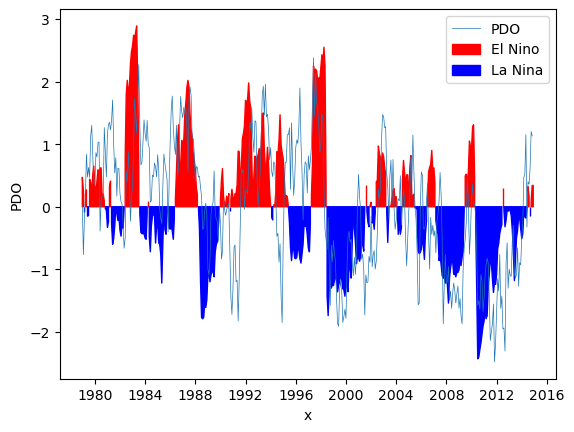

In [32]:
y1 = mei.value
sns.lineplot(data=pdo, x='x', y='PDO', label='PDO', linewidth=0.5)
plt.fill_between(x=mei.index, y1=mei.value, where=(y1>=0), color='red', label='El Nino')
plt.fill_between(x=mei.index, y1=mei.value, where=(y1<=0), color='blue', label='La Nina')
plt.legend()

In [33]:
q = pd.read_csv("Q_CGD.csv")
q['Month'] = 1
q['month shift'] = 12
q['date'] = pd.to_datetime(((q.Water_year * 10000 + 1) + q.Month * 100 + 1).apply(str), format='%Y%m%d')
df2 = q.apply(lambda x: x['date'] + pd.DateOffset(months = x['month shift']), axis=1)
q['Water Year'] = df2
q = q.set_index('Water Year')
q = q.drop(["Month", "month shift", 'date', 'Water_year'], axis=1)

In [34]:
import seaborn as sns
import pymannkendall as mk
from scipy import stats

In [35]:
x = dates.date2num(q.index)
res = stats.theilslopes(q.FWD, x)
res2 = stats.theilslopes(q.CGD, x)

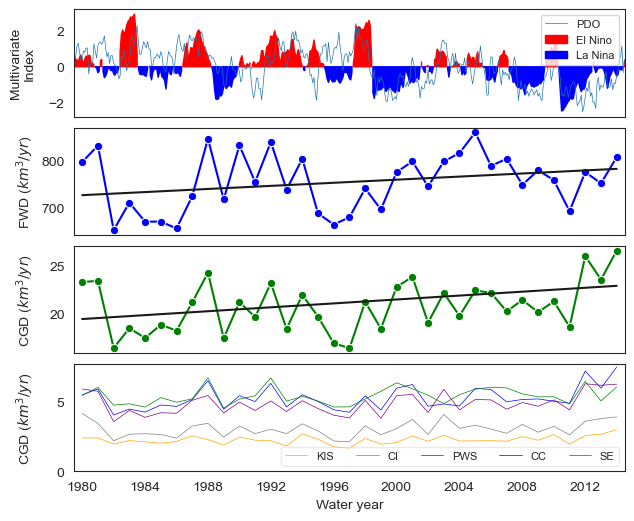

In [41]:
fig, axes = plt.subplots(4, 1, figsize=(7.1, 6), sharex=True)
sns.color_palette('pastel')
plt.subplots_adjust(wspace=0, hspace=0.1)

sns.lineplot(ax=axes[0], data=pdo, x='x', y='PDO', label='PDO', linewidth=0.5)

y1 = mei.value
axes[0].fill_between(x=mei.index, y1=mei.value, where=(y1>=0), color='red', label='El Nino')
axes[0].fill_between(x=mei.index, y1=mei.value, where=(y1<=0), color='blue', label='La Nina')
axes[0].set(ylabel= 'Multivariate\nIndex')
axes[0].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].legend(fontsize=8)

sns.lineplot(ax=axes[1], data=q, x=q.index, y="FWD", linestyle="-", marker='o', color='blue')
axes[1].plot(x, res[1] + res[0] * x, 'k-')
axes[1].set_ylabel('FWD ($km^3/yr$)')

sns.lineplot(ax=axes[2], data=q, x=q.index, y="CGD", linestyle="-", marker='o', color='green')
axes[2].plot(x, res2[1] + res2[0] * x, 'k-')
axes[2].set_ylabel('CGD ($km^3/yr$)')
axes[2].yaxis.set_minor_locator(AutoMinorLocator(5))

sns.lineplot(ax=axes[3], data=q, x=q.index, y="Kodiak Island/Shekilof", linestyle="-", color='orange',
             linewidth=0.5, label='KIS')
sns.lineplot(ax=axes[3], data=q, x=q.index, y="Cook Inlet", linestyle="-", color='grey',
             linewidth=0.5, label='CI')
sns.lineplot(ax=axes[3], data=q, x=q.index, y="Prince William Sound", linestyle="-", color='purple',
             linewidth=0.5, label='PWS')
sns.lineplot(ax=axes[3], data=q, x=q.index, y="Central Coast", linestyle="-", color='blue',
             linewidth=0.5, label='CC')
sns.lineplot(ax=axes[3], data=q, x=q.index, y="Southeast", linestyle="-", color='green',
             linewidth=0.5, label='SE')
axes[3].legend(loc='lower right', ncol=5, fontsize=8, framealpha=0.4)
axes[3].set(ylabel='CGD ($km^3/yr$)', xlabel='Water year', ylim=(0, 7.7), xlim=(3470.5, 16254.5))
axes[3].yaxis.set_minor_locator(AutoMinorLocator(5))
axes[3].xaxis.set_minor_locator(AutoMinorLocator(4))

fig.align_ylabels()

fig.savefig('Fig3.png', bbox_inches='tight', dpi=300)

In [36]:
data = q['CGD'].squeeze()
mk.original_test(data)

#slope/mean:
#increasing by 0.5%/yr
#total increase over 35 year model run: 17.5%

Mann_Kendall_Test(trend='increasing', h=True, p=0.0381342246927987, z=2.073409079290441, Tau=0.24705882352941178, s=147.0, var_s=4958.333333333333, slope=0.10201895782608694, intercept=19.49322393695652)

In [37]:
data2 = q['FWD'].squeeze()
mk.original_test(data2)

#increasing by 0.2%/yr
#total increase: 7%

Mann_Kendall_Test(trend='no trend', h=False, p=0.09948281525658187, z=1.6473661177924053, Tau=0.19663865546218487, s=117.0, var_s=4958.333333333333, slope=1.6276990473684176, intercept=727.2432269947369)

In [38]:
area = pd.read_csv("CGD_Area.csv")
area['q_cumsum']= area['qmean7913'].cumsum() / area['qmean7913'].sum()
area['A_cumsum']= area['CC_Area_km2'].cumsum() / area['CC_Area_km2'].sum()

In [39]:
df1 = area[area['CC_Area_km2'].between(1,5)]
df2 = area[area['CC_Area_km2'].between(6,10)]
df3 = area[area['CC_Area_km2'].between(11,15)]
df4 = area[area['CC_Area_km2'].between(16,20)]

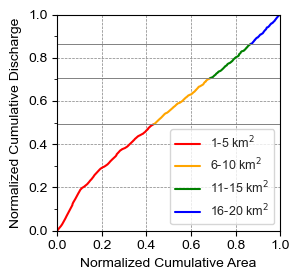

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(3.1, 2.9), sharex=True, sharey=True)
sns.set_style('white')

sns.lineplot(data=df1, x='A_cumsum', y='q_cumsum', label='1-5 km$^2$', color='red')
sns.lineplot(data=df2, x='A_cumsum', y='q_cumsum', label='6-10 km$^2$', color='orange')
sns.lineplot(data=df3, x='A_cumsum', y='q_cumsum', label='11-15 km$^2$', color='green')
sns.lineplot(data=df4, x='A_cumsum', y='q_cumsum', label='16-20 km$^2$', color='blue')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylabel('Normalized Cumulative Discharge')
ax.set_xlabel('Normalized Cumulative Area')
ax.set(xlim=(0,1), ylim=(0,1))
ax.grid(color='grey', linestyle='--', linewidth=0.5)

ax.legend(fontsize=9, loc="lower right")
fig.tight_layout()
ax.axhline(0.492, color='grey',ls='-', linewidth=0.69)
ax.axhline(0.705, color='grey',ls='-', linewidth=0.69)
ax.axhline(0.865, color='grey',ls='-', linewidth=0.69)

fig.savefig('Fig4.png', bbox_inches='tight', dpi=300)